In [85]:
import os
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import ConfusionMatrixDisplay
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


sns.set_style('darkgrid')



if not "root" in locals():
    current_path = Path(os.getcwd())
    root = current_path.parent.absolute()

## Preparing Data

In [86]:
os.chdir(root)
from data_treatment.box_creator import create_binary_box

df = pd.read_csv('database.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = create_binary_box(df, relative_threshold = 0.05, box_length=2).set_index(['Date']).dropna(axis = 0)
df[['PX_OPEN_VIX_volatility','Box']]

,PX_OPEN_VIX_volatility,Box
Date,,
2006-02-28,11.74,0
2006-03-01,12.05,0
2006-03-02,11.79,0
2006-03-03,12.03,0
2006-03-06,12.22,1
...,...,...
2021-05-18,18.89,1
2021-05-19,22.46,0
2021-05-20,22.33,0


In [87]:
def add_AR_cols(df: pd.DataFrame, lags: int, return_cols=False)-> pd.DataFrame:
    """
    added columns defined by VIX_lagged_i = VIX - VIX_-i
    :param df: DataFrame containing all variables
    :param lags: number of passed unit time added to the DataFrame
    :return: the DataFrame with the lagged columns
    """
    VIX = 'PX_OPEN_VIX_volatility'
    cols=[]

    for i in range(1,lags):
        df['VIX_LAG_' + str(i)] = df[VIX] - df[VIX].shift(i)
        cols.append('VIX_LAG_' + str(i))


    if return_cols: return df.dropna(), cols
    else: return df.dropna()

In [88]:
df, cols = add_AR_cols(df,7, return_cols=True)


cols += ["PX_OPEN_VIX_volatility",'S&P 500 Weekly Close_SENTIMENT' ]

In [89]:
X = df[cols]
y = df['Box']
X_sm = sm.add_constant(X)


## Training models

### Statsmodel to search for pertinent exogenes variables

In [90]:
log_reg = sm.Logit(y,X_sm)
print(log_reg.fit().summary())

Optimization terminated successfully.
         Current function value: 0.504303
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                    Box   No. Observations:                 2413
Model:                          Logit   Df Residuals:                     2404
Method:                           MLE   Df Model:                            8
Date:                Tue, 04 Jan 2022   Pseudo R-squ.:                0.002871
Time:                        01:25:11   Log-Likelihood:                -1216.9
converged:                       True   LL-Null:                       -1220.4
Covariance Type:            nonrobust   LLR p-value:                    0.5358
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -1.4613      0.197     -7.430     

'VIX_LAG_5','S&P 500 Weekly Close_SENTIMENT' ne sont pas significatifs (à 10%)

### scikit-learn to use penalization

In [91]:
X.drop(['VIX_LAG_5','S&P 500 Weekly Close_SENTIMENT' ], axis=1, inplace=True)

/Users/g0bel1n/PycharmProjects/pythonProject/basic_env/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [92]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

pipe_LogReg = make_pipeline(StandardScaler(),LogisticRegressionCV(fit_intercept=True, cv = 10, penalty='l1', solver='saga', l1_ratios=[0.8, 0.4]))
pipe_LogReg.fit(X_train,y_train)

score = pipe_LogReg.score(X_train, y_train)
print("Score: ", score)


/Users/g0bel1n/PycharmProjects/pythonProject/basic_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:2064: UserWarning: l1_ratios parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


Score:  0.7932642487046632


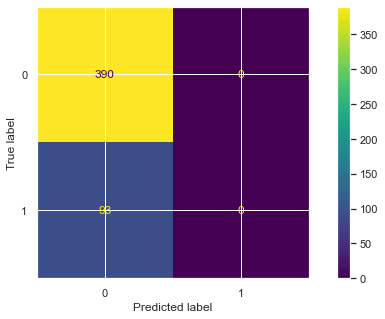

In [93]:
ConfusionMatrixDisplay.from_estimator(estimator=pipe_LogReg, X=X_test, y=y_test)

In [94]:
y_pred = pipe_LogReg.predict(X_test)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [95]:
pipe_RF = pipe_LogReg = make_pipeline(StandardScaler(),RandomForestClassifier())
pipe_RF.fit(X_train,y_train)

score = pipe_RF.score(X_test, y_test)
print("Score: ", score)

y_pred = pipe_RF.predict(X_test)
y_pred

Score:  0.7888198757763976


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [96]:
import matplotlib.pyplot as plt 
sns.set(rc={'figure.figsize':(10,5)})


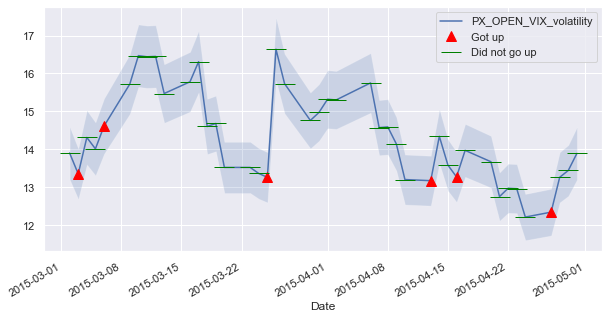

In [99]:
df1 = df['2015-03':'2015-04']

fig, ax = plt.subplots()
base = df1['PX_OPEN_VIX_volatility'].plot(ax=ax)


got_out = df1.loc[df1['Box']==1]
no_got_out = df1.loc[df1['Box']==0]



ax.plot(got_out.index.values, got_out['PX_OPEN_VIX_volatility'], '^', markersize=10, color='red', lw=2, label='Got up')
ax.plot(no_got_out.index, no_got_out['PX_OPEN_VIX_volatility'], '_', markersize = 20, color='green', lw=2, label='Did not go up');  
ax.fill_between(df1.index, df1['PX_OPEN_VIX_volatility']*(1.05), df1['PX_OPEN_VIX_volatility']*(0.95), alpha=0.2)
plt.legend(loc='best')
plt.show()

<AxesSubplot:xlabel='Date'>

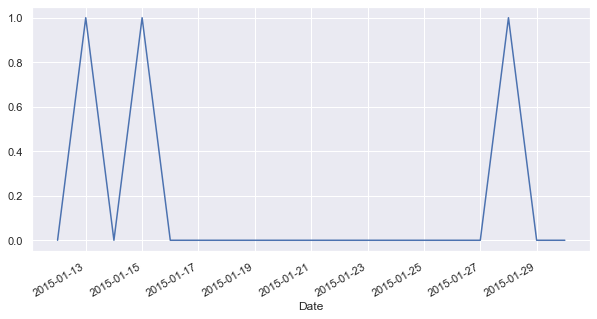

In [102]:
df['Box']['2015-01'].plot()
